In [10]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import random
from catboost import CatBoostClassifier, Pool
import torch

warnings.filterwarnings("ignore")

In [5]:
def seed_everything(seed=7575):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.random.manual_seed(seed)


seed_everything()

### Train

In [236]:
train_data = pd.read_csv("Задача3. Датасет 1. Тренировочный.csv", encoding="cp1251", sep=';', skiprows=[1, 2])

### Val

In [237]:
val_data = pd.read_csv("Задача3. Датасет 2. Тестовый.csv", encoding="cp1251", sep=';', skiprows=[1, 2])

val_data = val_data.rename(columns={'Unnamed: 0': "Параметр"})


### Feature Engineering

In [273]:
drop_feat = [
    'х001', 'х002', 'х003', 'х004', 'х006', 'х005', 'х007',
    'х031', 'х032', 'х033', 'х034', 'х035','х036', 'х038','х039', 'х040', 'х041', 'х042',
    'х045', 'х046', 'х047', 'х048', 'х049', 'х050', 'х051', 'х052','х053', 'х054','х055', 'х056',
    'х058', 'х059', 'х025', 'х026',
]

In [274]:
train_data_diff = train_data.drop(drop_feat, axis=1).drop(['Параметр', 'Маркер'], axis=1).diff(1)
train_data_diff.rename(columns={col: col + "_diff" for col in train_data_diff.columns}, inplace=True)
train = pd.concat([train_data, train_data_diff], axis=1)

val_data_diff = val_data.drop(drop_feat, axis=1).drop(['Параметр', 'Маркер'], axis=1).diff(1)
val_data_diff.rename(columns={col: col + "_diff" for col in val_data_diff.columns}, inplace=True)
val = pd.concat([val_data, val_data_diff], axis=1)

In [275]:
# заменим 2 на 1 и 4 на 3 в Train и Val
X = train.drop(['Параметр', 'Маркер'], axis=1).reset_index(drop=True)
y = train[['Маркер']].reset_index(drop=True)

y[y['Маркер'] == 2] = 1
y[y['Маркер'] == 4] = 3


X_val, y_val = val.drop(['Параметр', 'Маркер'], axis=1).reset_index(drop=True), val[['Маркер']]

y_val[y_val['Маркер'] == 2] = 1
y_val[y_val['Маркер'] == 4] = 3

### Modeling

In [287]:
model = CatBoostClassifier(verbose=200, od_type="Iter", od_wait=100, depth=12,
                           # colsample_bylevel=.5
                           learning_rate=.01
                           )

model.fit(X, y, eval_set=(X_val, y_val))

0:	learn: 0.6476005	test: 0.6915298	best: 0.6915298 (0)	total: 242ms	remaining: 4m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6915297693
bestIteration = 0

Shrink model to first 1 iterations.


In [288]:
pred = model.predict(X_val)
print(f'Кол-во предсказанных нулей и единиц: {Counter(pred)}')


Кол-во предсказанных нулей и единиц: Counter({1: 6274, 3: 599})


### Test

In [278]:
test_data = pd.read_csv("Задача3. Датасет 3. Контрольный для участников.csv", encoding="cp1251", sep=';', skiprows=[1])
test_data.reset_index(drop=True, inplace=True)

In [279]:
test = test_data.loc[:, 'х001':'х071'].dropna()

test_data_diff = test.drop(drop_feat, axis=1).diff(1)
test_data_diff.rename(columns={col: col + "_diff" for col in test_data_diff.columns}, inplace=True)
test = pd.concat([test, test_data_diff], axis=1)

In [289]:
pred_test = model.predict(test)
print(f'Кол-во предсказанных нулей и единиц в тесте: {Counter(pred_test)}')

pred_df = pd.DataFrame(data=pred_test, columns=["pred"])
pred_df[pred_df["pred"] == 3]

Кол-во предсказанных нулей и единиц в тесте: Counter({1: 6611})


,pred


### Inference

In [290]:
sample_submission = pd.read_csv("sample_submission_3.csv", encoding="cp1251", sep=';')

In [291]:
ans = test_data.copy()

ind_two, ind_four = 6470, 8050


ans['Маркер'] = 1
ans.loc[ind_two, "Маркер"] = 2
ans.loc[ind_two+1:ind_four, "Маркер"] = 3
ans.loc[ind_four, "Маркер"] = 4
ans.loc[ind_four, "Unnamed: 0"] = "11.10.2019 6:19"

In [292]:
res = pd.concat([sample_submission, ans])
res.shape

(36664, 73)

In [293]:
res.reset_index(drop=True).to_csv("ds3_.csv", index=False, sep=';', encoding='cp1251')

In [39]:
# 6522 - много
# 6480 - лучше чем 6500
# 6450 хуже чем 6480
# 6470 хуже чем 6480

### Fourier

array([           inf, 2.00000000e-03, 1.00000000e-03, ...,
       2.22866057e-08, 2.22863574e-08, 2.22861091e-08])

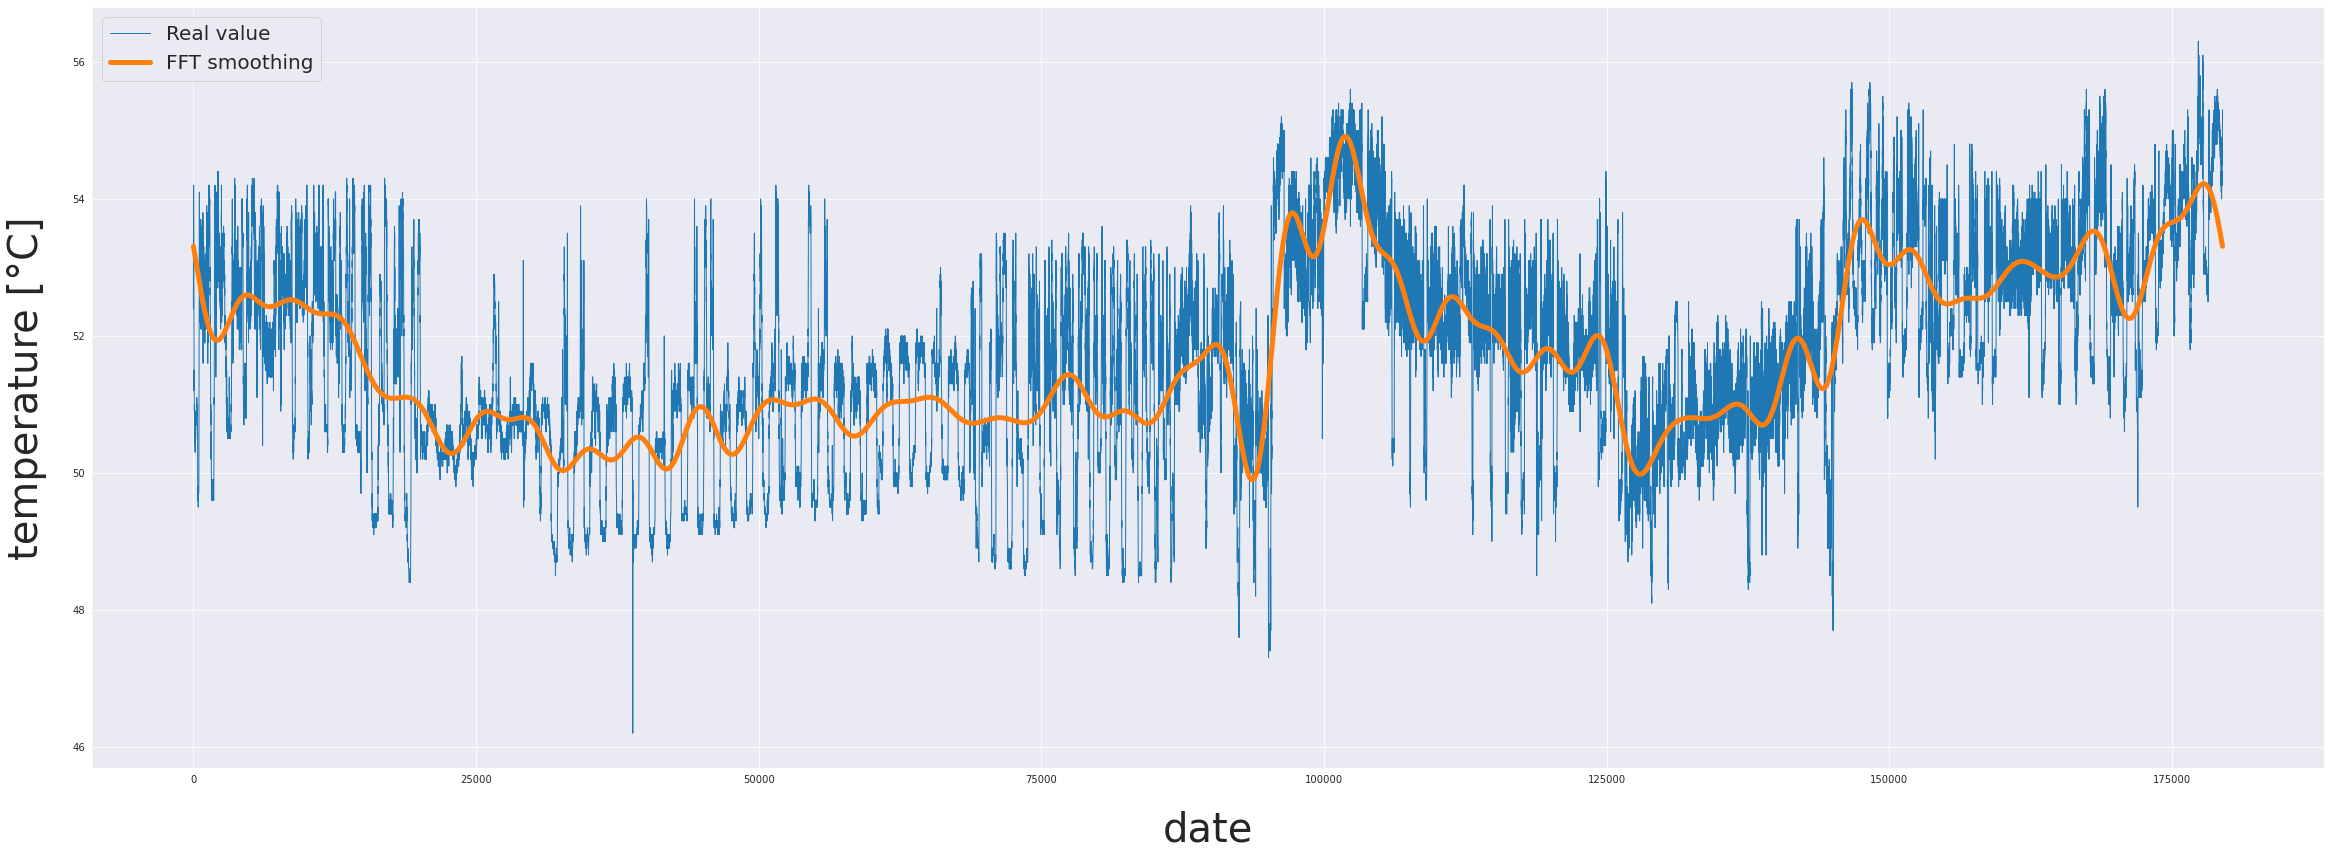

In [152]:
ts = train_data[['х019']]

def low_pass(s, threshold=2e4):
    fourier = np.fft.rfft(s)
    frequencies = np.fft.rfftfreq(s.size, d=2e-3 / s.size)
    display(1/frequencies)
    fourier[frequencies > threshold] = 0
    return np.fft.irfft(fourier)


a = low_pass(ts['х019'])
# ts = ts[1:]
ts['temperature_smoothed'] = a

fig = plt.figure(figsize=(40,14))
plt.xlabel('date',fontsize=40, labelpad=25)
plt.ylabel('temperature [°C]',fontsize=40, labelpad=25)
plt.plot(ts['х019'], linewidth=1)
plt.plot(ts['temperature_smoothed'], linewidth=5)
plt.legend(['Real value','FFT smoothing'], prop={'size': 20})
plt.title('',fontsize=40, pad=30)

plt.show()


In [ ]:
data = pd.DataFrame()

for col in train_data.columns.tolist()[1:-1]:

    a = low_pass(train_data[col])
    data[col+'_f'] = a

In [ ]:
data_2 = pd.DataFrame()

for col in val_data.columns.tolist()[1:-1]:

    a = low_pass(val_data[col])
    data_2[col+'_f'] = a

In [164]:
X = data
y = train[['Маркер']].reset_index(drop=True)

y[y['Маркер'] == 2] = 1
y[y['Маркер'] == 4] = 3


X_val, y_val = data_2, val[['Маркер']]

y_val[y_val['Маркер'] == 2] = 1
y_val[y_val['Маркер'] == 4] = 3

In [233]:
model = CatBoostClassifier(verbose=200, od_type="Iter", od_wait=100, depth=8,
                           colsample_bylevel=.4, learning_rate=.1
                           )

model.fit(X, y, eval_set=(X_val, y_val[1:]))

0:	learn: 0.3495185	test: 0.6913366	best: 0.6913366 (0)	total: 32.9ms	remaining: 32.8s
200:	learn: 0.0000162	test: 0.4578840	best: 0.4578840 (200)	total: 10.1s	remaining: 40.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4574137065
bestIteration = 275

Shrink model to first 276 iterations.


In [234]:
pred = model.predict(X_val)
print(f'Кол-во предсказанных нулей и единиц: {Counter(pred)}')

Кол-во предсказанных нулей и единиц: Counter({1: 6778, 3: 94})


In [ ]:
test_ = test_data.loc[:, 'х001':'х071'].dropna()

data_3 = pd.DataFrame()

for col in test_.columns.tolist():

    a = low_pass(val_data[col])
    data_3[col+'_f'] = a

In [229]:
pred_test = model.predict(data_3)
print(f'Кол-во предсказанных нулей и единиц в тесте: {Counter(pred_test)}')

pred_df = pd.DataFrame(data=pred_test, columns=["pred"])
pred_df[pred_df["pred"] == 3]

Кол-во предсказанных нулей и единиц в тесте: Counter({1: 6475, 3: 397})


,pred
1117,3
1118,3
1119,3
1120,3
1121,3
...,...
5104,3
5105,3
5106,3
5107,3
